# DM-35283: Process Diffim sprint dataset with new Image Differencing

### Using the 2021 diffim sprint data, make the usual diagnostic plots for characterizing diffim performance in different configurations after bugfixes include in w_2022_46. We begin with using a collection of the best third seeing templates and forcing the convolveTemplate option in subtractImages with an earlier weekly as the baseline.

### The other configurations include: best third seeing templates, force convolve template; middle third seeing templates, force convolve science; best thirs seeing templates, auto mode; middle third seeing templates, auto mode.


In [1]:
import sys
from lsst.daf.butler import Butler
import lsst.daf.butler as dafButler
import lsst.geom
import lsst.afw.display as afwDisplay
import lsst.afw.display as afw_display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.ndimage
afwDisplay.setDefaultBackend('matplotlib') 
from lsst.pipe.tasks.scaleZeroPoint import ScaleZeroPointTask
task = ScaleZeroPointTask()

from types import SimpleNamespace
from astropy.visualization import (ZScaleInterval, SqrtStretch, ImageNormalize)
from astropy.coordinates import Angle, Latitude, Longitude
from astropy import units as u

from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
from lsst.pipe.base import Struct

import IPython
from IPython.display import IFrame

from lsst.analysis.ap import legacyApdbUtils, legacyCoaddAnalysis, legacyPlotUtils

Overriding default configuration file with /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-5.0.0/Linux64/dustmaps_cachedata/g41a3ec361e+62d12e78cb/config/.dustmapsrc


In [2]:
repo = '/sdf/group/rubin/repo/main'
butler = dafButler.Butler(repo)

Each run mode will get its own namespace here. Note that "new_convolveTemplate" has the same seetings as "best_convoleTemplate", but is with an earlier release.

In [3]:
new_convolveTemplate = SimpleNamespace(collection = 'u/kherner/DM-35283/baselineWithFakes_bestThirdSeeing_convolveTemplate',
                                       apdb = 'lsst-devl',
                                       schema='kherner_dm35283_convolveTemplate',
                                      templName='goodSeeing')
best_convolveTemplate = SimpleNamespace(collection = 'u/kherner/DM-35283/w46_bestThirdSeeing_convolveTemplate',
                                       apdb = 'lsst-devl',
                                       schema='kherner_dm35283_w46_convolvetemplate',
                                      templName='goodSeeing')
mid_convolveScience = SimpleNamespace(collection = 'u/kherner/DM-35283/w46_midThirdSeeing_convolveScience',
                                       apdb = 'lsst-devl',
                                       schema='kherner_dm35283_w46_convolvescience',
                                      templName='goodSeeing')
best_auto = SimpleNamespace(collection = 'u/kherner/DM-35283/w46_bestThirdSeeing_autoMode',
                                       apdb = 'lsst-devl',
                                       schema='kherner_dm35283_w46_bestthird_auto',
                                      templName='goodSeeing')
mid_auto = SimpleNamespace(collection = 'u/kherner/DM-35283/w46_midThirdSeeing_autoMode',
                                       apdb = 'lsst-devl',
                                       schema='kherner_dm35283_w46_midthird_auto',
                                      templName='goodSeeing')
all_auto = SimpleNamespace(collection = 'u/kherner/DM-35283/w46_all_autoMode',
                                       apdb = 'lsst-devl',
                                       schema='kherner_dm35283_w46_all_auto',
                                      templName='goodSeeing')

Same as the default bad flag list, but kept in here as a reminder of what they are and to make it easy to change them.

In [4]:
badFlagList = ['base_PixelFlags_flag_bad',
               'base_PixelFlags_flag_suspect',
               'base_PixelFlags_flag_saturatedCenter',
               'base_PixelFlags_flag_interpolated',
               'base_PixelFlags_flag_interpolatedCenter',
               'base_PixelFlags_flag_edge',
              ]

In [5]:
apdbs_nonempty = [ new_convolveTemplate, best_convolveTemplate, mid_convolveScience, best_auto, mid_auto]

Print all diaSource and good diaSource counts

In [6]:
for run in apdbs_nonempty:
    collection = run.collection
    apdb = run.apdb
    schema = run.schema
    objTable, srcTable, goodObj, goodSrc = legacyApdbUtils.loadTables(repo,
                                                          dbType='postgres',
                                                          dbName=apdb,
                                                          schema=schema,
                                                          instrument='HSC',
                                                          )
    print(f'{len(srcTable):7d}\t{len(goodSrc):7d}\t\t{collection.split("/")[-1]}')

/tmp/ipykernel_7340/845821933.py:5: FutureWarning: Call to deprecated function (or staticmethod) loadTables. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable, srcTable, goodObj, goodSrc = legacyApdbUtils.loadTables(repo,
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:248: FutureWarning: Call to deprecated function (or staticmethod) loadAllApdbObjects. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable = loadAllApdbObjects(dbPath, dbType=dbType,
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:481: FutureWarning: Call to deprecated function (or staticmethod) connectToApdb. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  connection = connectToApdb(dbName, dbType, schema)
/sd

  54593	  13111		baselineWithFakes_bestThirdSeeing_convolveTemplate


/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:248: FutureWarning: Call to deprecated function (or staticmethod) loadAllApdbObjects. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable = loadAllApdbObjects(dbPath, dbType=dbType,
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:481: FutureWarning: Call to deprecated function (or staticmethod) connectToApdb. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  connection = connectToApdb(dbName, dbType, schema)
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:485: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  objTab

  54762	  13255		w46_bestThirdSeeing_convolveTemplate


/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:248: FutureWarning: Call to deprecated function (or staticmethod) loadAllApdbObjects. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable = loadAllApdbObjects(dbPath, dbType=dbType,
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:481: FutureWarning: Call to deprecated function (or staticmethod) connectToApdb. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  connection = connectToApdb(dbName, dbType, schema)
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:485: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  objTab

  64466	  27694		w46_midThirdSeeing_convolveScience


/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:248: FutureWarning: Call to deprecated function (or staticmethod) loadAllApdbObjects. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable = loadAllApdbObjects(dbPath, dbType=dbType,
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:481: FutureWarning: Call to deprecated function (or staticmethod) connectToApdb. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  connection = connectToApdb(dbName, dbType, schema)
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:485: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  objTab

  54227	  14348		w46_bestThirdSeeing_autoMode


/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:248: FutureWarning: Call to deprecated function (or staticmethod) loadAllApdbObjects. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable = loadAllApdbObjects(dbPath, dbType=dbType,
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:481: FutureWarning: Call to deprecated function (or staticmethod) connectToApdb. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  connection = connectToApdb(dbName, dbType, schema)
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:485: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  objTab

  56162	  18453		w46_midThirdSeeing_autoMode


/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:443: FutureWarning: Call to deprecated function (or staticmethod) addTableMetadata. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  addTableMetadata(sourceTable, butler=butler, instrument=instrument)


### Randomly choose a visit and detector to make some diagnostic plots

In [7]:
oneVisit = 1220
oneDetector = 66
selname = 'fakes_goodSeeing'

diffim variance median
----------------------
714.118164	baselineWithFakes_bestThirdSeeing_convolveTemplate
711.499634	w46_bestThirdSeeing_convolveTemplate
725.967529	w46_midThirdSeeing_convolveScience
711.499634	w46_bestThirdSeeing_autoMode
725.967529	w46_midThirdSeeing_autoMode


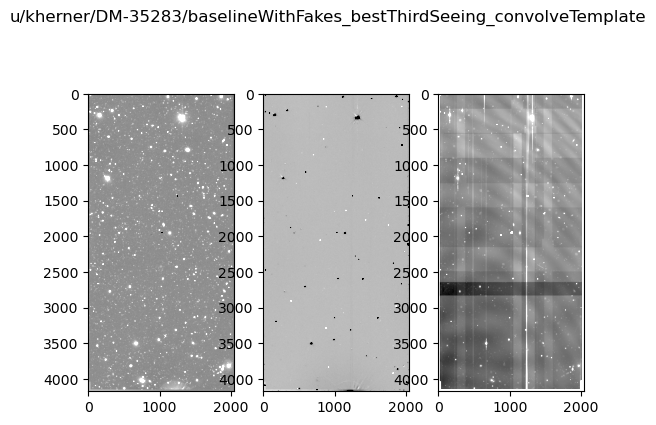

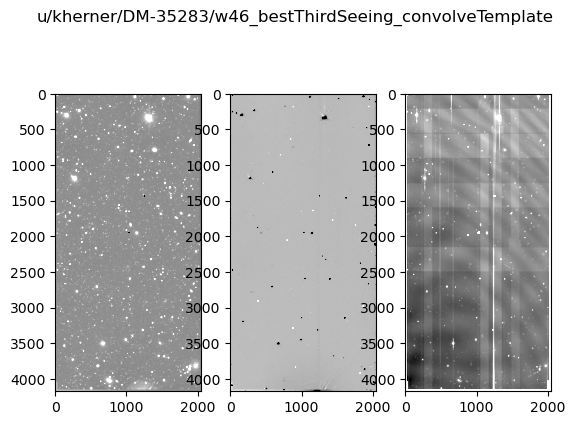

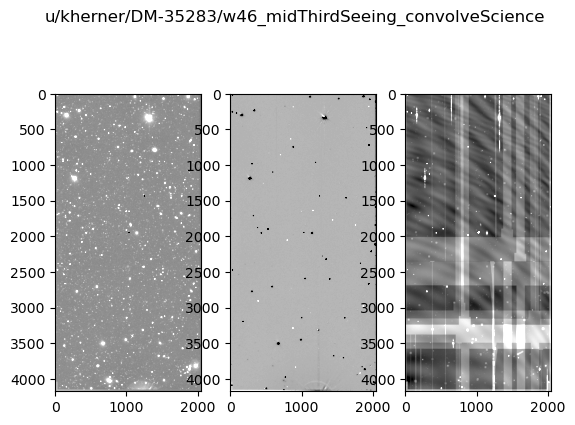

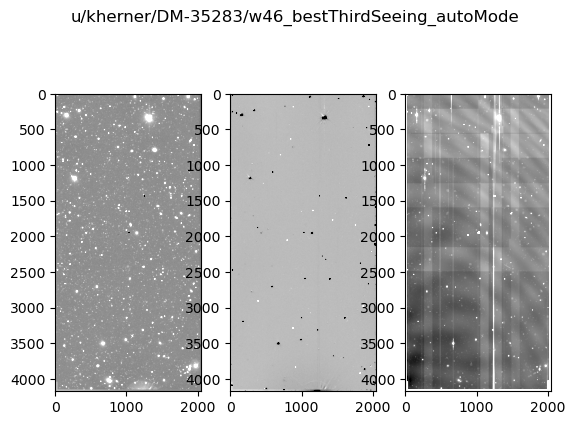

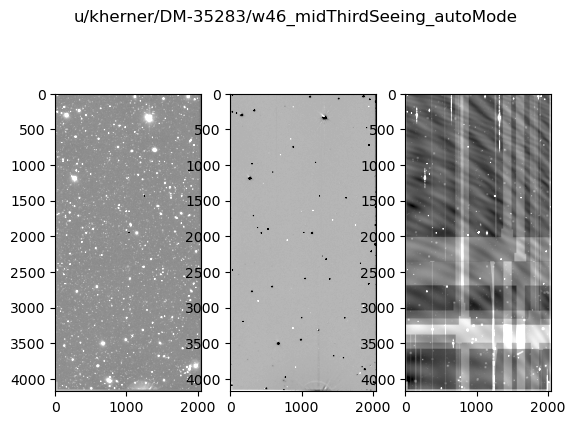

In [8]:
collection_list = [ i.collection for i in apdbs_nonempty ]
print(f'diffim variance median')
print(f'----------------------')
for collections in collection_list:
#for collections in [default_best.collection, preconvolve_best.collection]:
    calexp = butler.get('calexp', instrument='HSC',
                        visit=oneVisit, detector=oneDetector, collections=collections)
    diffim = butler.get(selname+'Diff_differenceExp', instrument='HSC',
                        visit=oneVisit, detector=oneDetector, collections=collections)

    calexpNorm = ImageNormalize(calexp.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
    diffimNorm = ImageNormalize(diffim.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
    diffimVarNorm = ImageNormalize(diffim.variance.array, interval=ZScaleInterval(), stretch=SqrtStretch())

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle(collections)
    ax1.imshow(calexp.image.array, cmap='gray', norm=calexpNorm)
    ax2.imshow(diffim.image.array, cmap='gray', norm=diffimNorm)
    ax3.imshow(diffim.variance.array, cmap='gray', norm=diffimVarNorm)
    
    print(f'{np.median(diffim.variance.array):8f}\t{collections.split("/")[-1]}')

### In the previous plot, you'll immediately significant banding effects in the diffim variance plane. We've verified that it's coming from where the sensor edges are, and they are appropriately flagged (see below). Since this is a small, carefully curated dataset with a relatively small number of templates, those effects are more visible than usual.

In [9]:
def makeplots(run):
    collection = run.collection
    apdb = run.apdb
    schema=run.schema
    templName=run.templName
    dbPath = apdb
    objTable, srcTable, goodObj, goodSrc = legacyApdbUtils.loadTables(repo,
                                                          dbType='postgres',
                                                          dbName=dbPath,
                                                          schema=schema,
                                                          instrument='HSC')
    #srcTable = legacyApdbUtils.addVisitDetectorToSrcTable(srcTable, instrument='HSC', butler=butler)
    flagTable, srcTableFlags, flagFilter, goodSrc, goodObj = legacyApdbUtils.makeSrcTableFlags(srcTable,
                                                                                         objTable,
                                                                                         instrument='HSC',
                                                                                         repo=repo)
    # Good DIA Sources
    fig = plt.figure(figsize=(4,4))
    xlim = (150.45, 149.8)
    ylim = (2.1, 2.5)
    ax = fig.add_subplot(111)
    plt.setp(ax, xlim=xlim, ylim=ylim)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.scatter(goodSrc['ra'], goodSrc['decl'], c='C0', s=0.1, marker='o', alpha=0.4)
    ax.set_xlabel('RA (deg)')
    ax.set_ylabel('Dec (deg)')
    ax.set_title(f'DIA Sources ({str(collection).split("/")[-1]})')
    
    # Good DIA Sources by visit
    bandList = ['g', 'r']
    colorList = ['C2', 'C1']
    for band, color in zip(bandList, colorList):
        legacyPlotUtils.plotDiaSourcesOnSkyGrid(repo, goodSrc.loc[goodSrc['filterName'] == band],
                                    title=band+' band', color=color, size=5)
    
    # How many DIA Sources comprise each DIA Object
    hist = legacyPlotUtils.plotDiaObjectHistogram(objTable, goodObj)
    
    # Flag bar chart
    legacyPlotUtils.plotFlagHist(srcTable, badFlagList=badFlagList)
    
    # Flux distributions
    legacyPlotUtils.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == 'g'], fluxType='psFlux',
                        title='DIA Sources, HSC-G, Diffim PSF Flux', color1='C2', binmin=-1e3, binmax=1e3)
    legacyPlotUtils.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == 'r'], fluxType='psFlux',
                        title='DIA Sources, HSC-R, Diffim PSF Flux', color1='C1', binmin=-1e3, binmax=1e3)
    legacyPlotUtils.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == 'g'], fluxType='totFlux',
                        title='DIA Sources, HSC-G, Calexp PSF Flux', color1='C2', binmin=-1e3, binmax=2e3)
    legacyPlotUtils.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == 'r'], fluxType='totFlux',
                        title='DIA Sources, HSC-R2, Calexp PSF Flux', color1='C1', binmin=-1e3, binmax=2e3)
    
    # Flux histograms
    legacyPlotUtils.source_magnitude_histogram(repo, goodSrc, 'g', 'HSC', collection)
    legacyPlotUtils.source_magnitude_histogram(repo, goodSrc, 'r', 'HSC', collection)
    
    # A few cutouts
    for index, source in goodSrc[:4].iterrows():
        dataId = {'detector': int(goodSrc['detector'][index]), 'visit': int(goodSrc['visit'][index]), 'instrument': 'HSC'}
        center = lsst.geom.SpherePoint(goodSrc['ra'][index], goodSrc['decl'][index], lsst.geom.degrees)
        scienceCutout, differenceCutout, TemplateCutout = legacyPlotUtils.retrieveCutouts(butler,
                                                                              dataId,
                                                                              collection,
                                                                              center,
                                                                             diffName='fakes_goodSeeing')
        legacyPlotUtils.plotCutout(scienceCutout, differenceCutout, TemplateCutout)

### Plot source locations and usual diagostic plots. Nothing particularly controversial here.

/tmp/ipykernel_7340/730056244.py:7: FutureWarning: Call to deprecated function (or staticmethod) loadTables. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable, srcTable, goodObj, goodSrc = legacyApdbUtils.loadTables(repo,
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:248: FutureWarning: Call to deprecated function (or staticmethod) loadAllApdbObjects. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable = loadAllApdbObjects(dbPath, dbType=dbType,
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:481: FutureWarning: Call to deprecated function (or staticmethod) connectToApdb. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  connection = connectToApdb(dbName, dbType, schema)
/sd

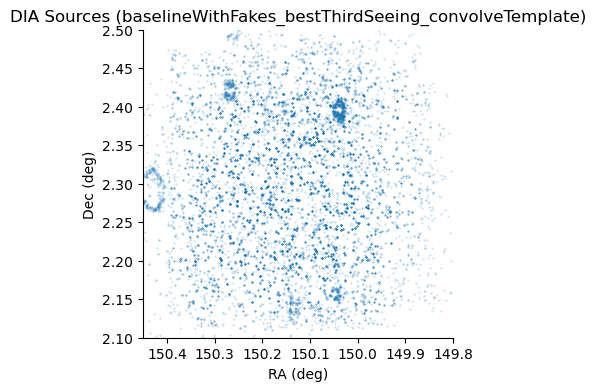

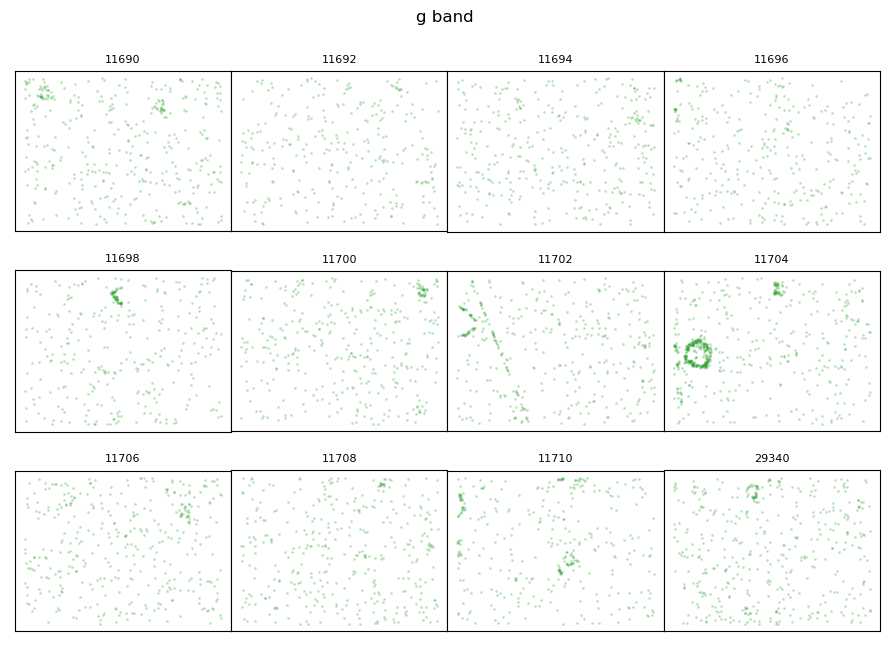

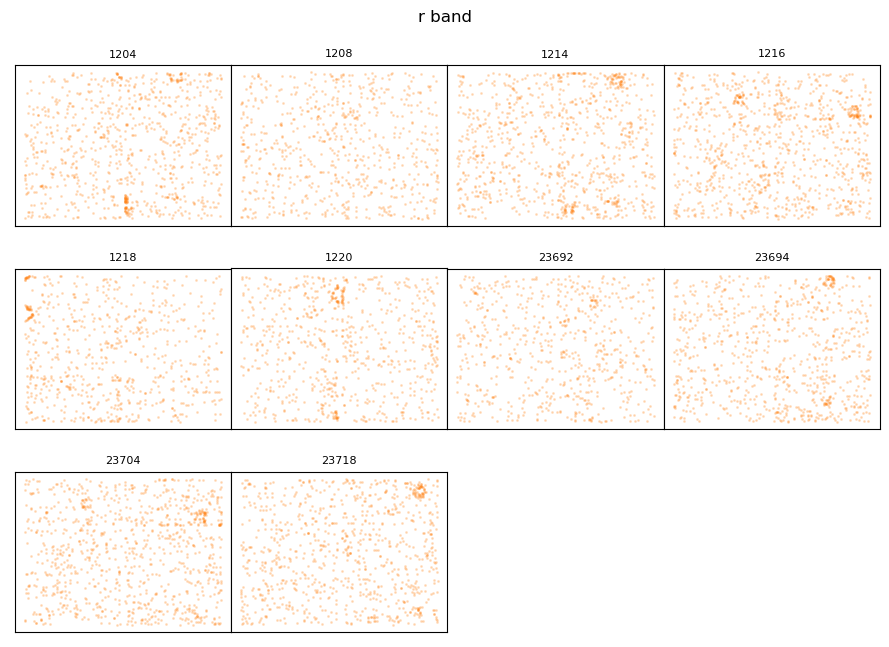

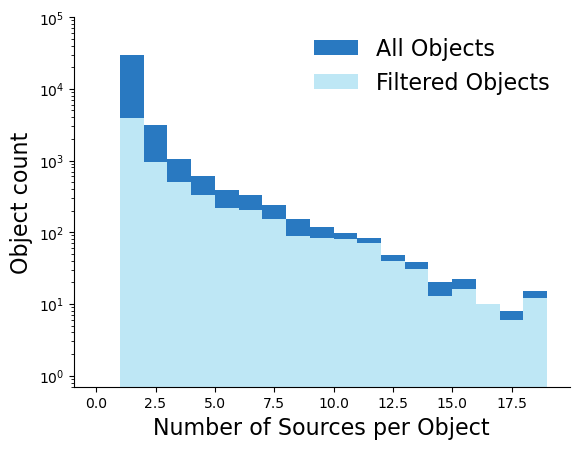

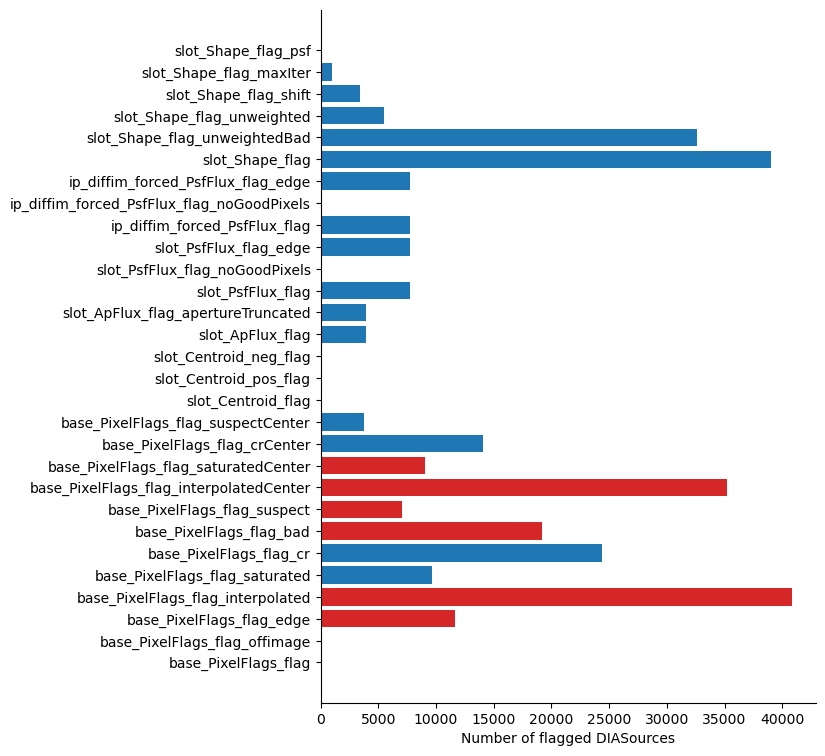

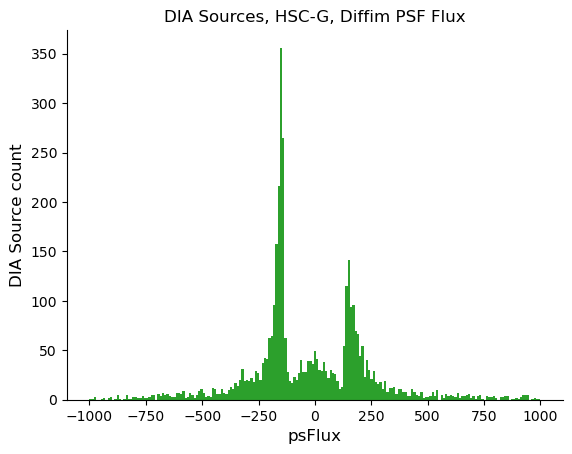

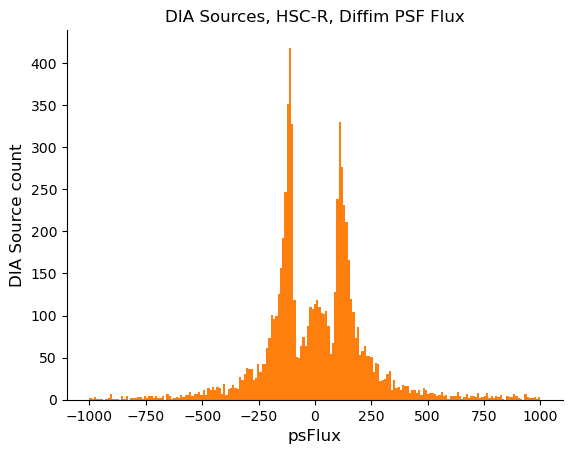

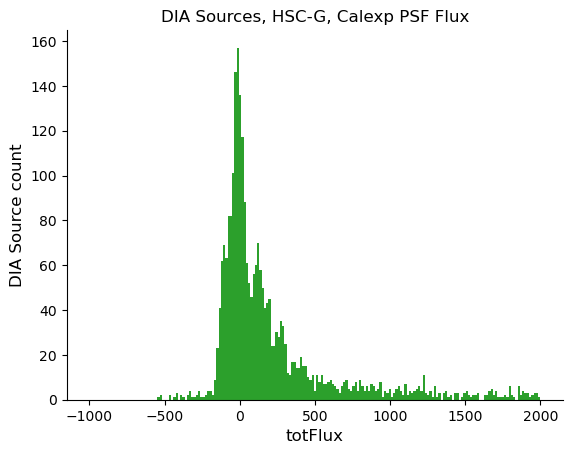

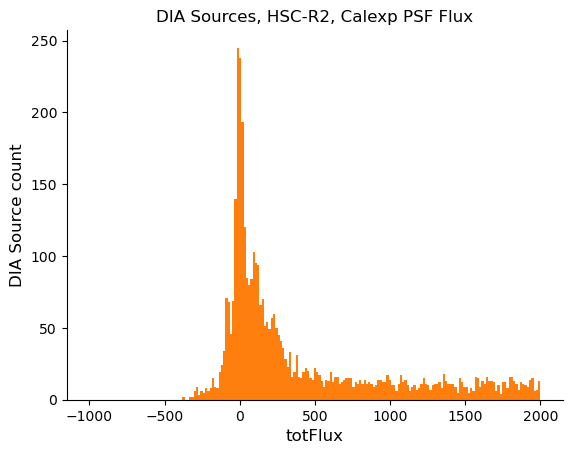

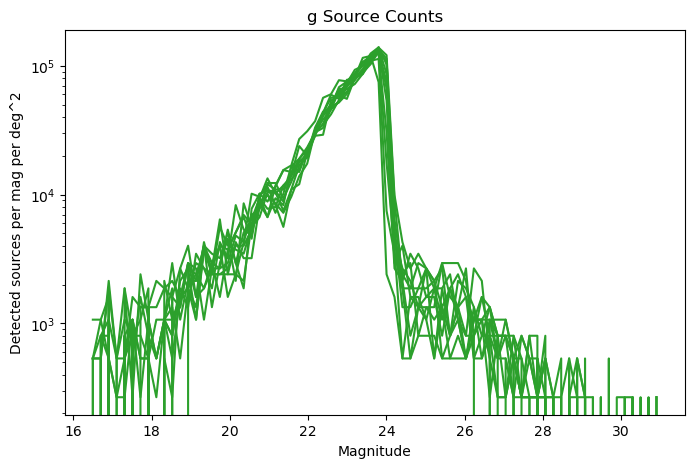

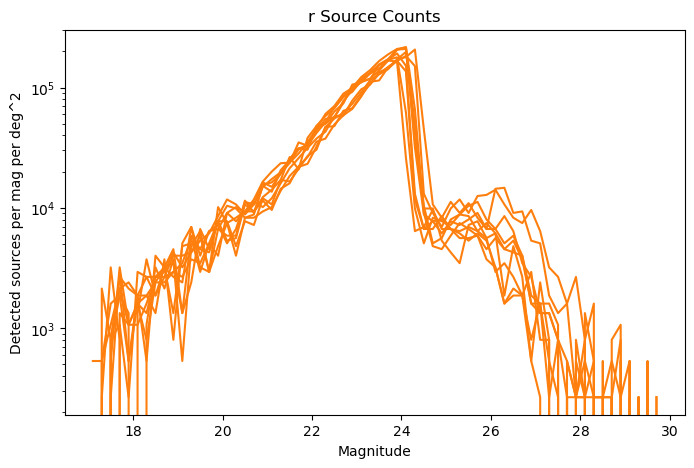

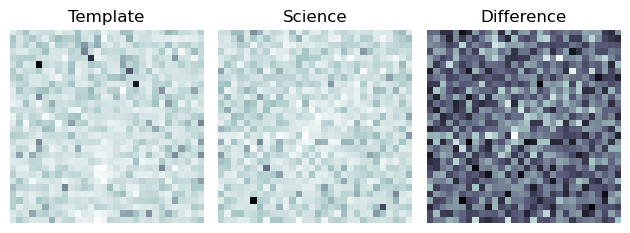

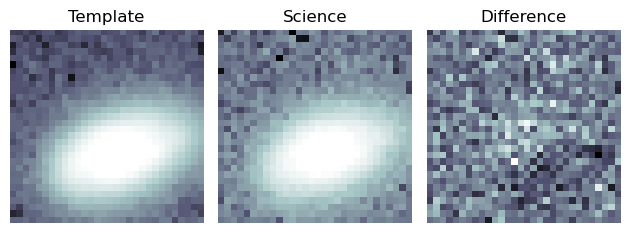

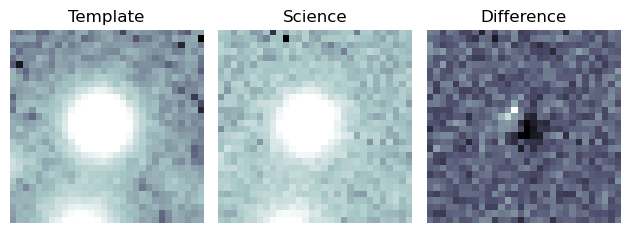

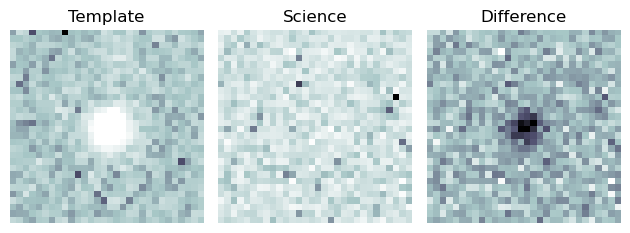

In [10]:
makeplots(new_convolveTemplate)

In [11]:
def allTables(run):

    collection = run.collection
    apdb = run.apdb
    schema=run.schema
    dbPath = apdb

    objTable, srcTable, goodObj, goodSrc = legacyApdbUtils.loadTables(repo,
                                                          dbType='postgres',
                                                          dbName=dbPath,
                                                          schema=schema,
                                                          instrument='HSC')
    
    flagTable, srcTableFlags, flagFilter, goodSrc, goodObj = legacyApdbUtils.makeSrcTableFlags(srcTable,
                                                                                         objTable,
                                                                                   instrument='HSC',
                                                                                   repo=repo)
    
    return flagTable, srcTableFlags, flagFilter, goodSrc, goodObj, objTable, srcTable

### Plot source locations

/tmp/ipykernel_7340/743899088.py:8: FutureWarning: Call to deprecated function (or staticmethod) loadTables. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable, srcTable, goodObj, goodSrc = legacyApdbUtils.loadTables(repo,
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:248: FutureWarning: Call to deprecated function (or staticmethod) loadAllApdbObjects. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable = loadAllApdbObjects(dbPath, dbType=dbType,
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:481: FutureWarning: Call to deprecated function (or staticmethod) connectToApdb. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  connection = connectToApdb(dbName, dbType, schema)
/sd

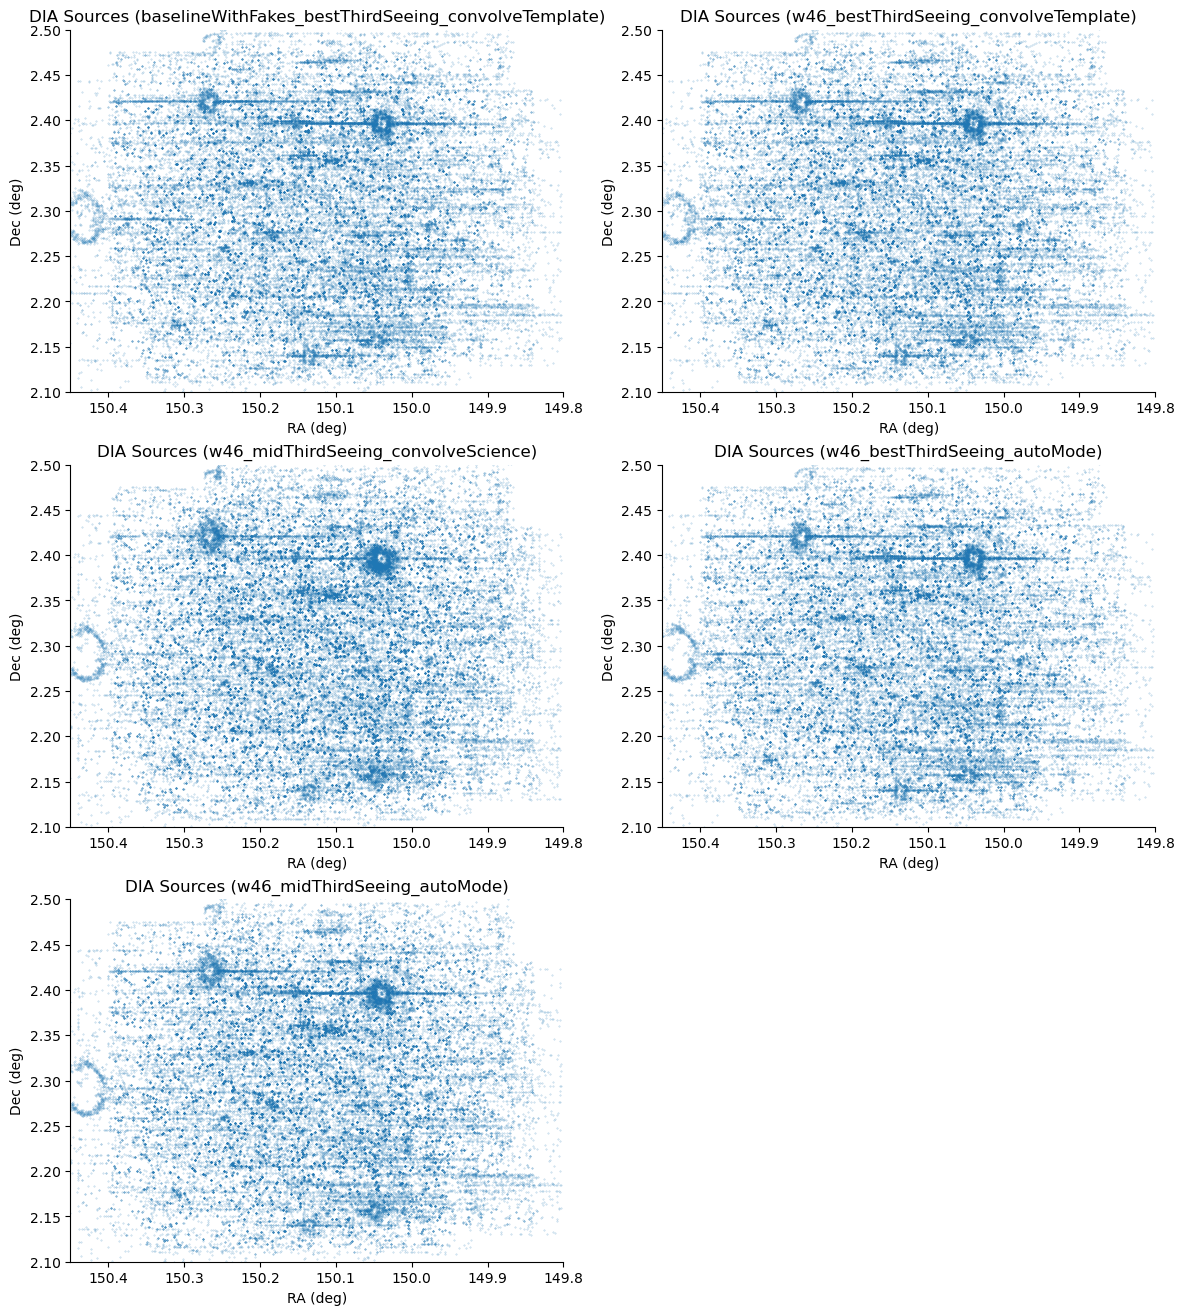

In [12]:
 # Good DIA Sources
fig = plt.figure(figsize=[14.0, 16.0])
gspec = fig.add_gridspec(3, 2)
xlim = (150.45, 149.8)
ylim = (2.1, 2.5)
iplt = 0
fluxType='psFlux'
for collection in apdbs_nonempty:
    flagTable, srcTableFlags, flagFilter, goodSrc, goodObj, objTable, srcTable = allTables(collection)
    fluxcut = 1500.0 # value of 1500 determined below.
    BS = srcTable.loc[abs(srcTable[fluxType])>=fluxcut]
    goodBS = goodSrc.loc[abs(goodSrc[fluxType])>=fluxcut]
    ax = fig.add_subplot(gspec[int(iplt/2),iplt%2])
    plt.setp(ax, xlim=xlim, ylim=ylim)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.scatter(srcTable['ra'], srcTable['decl'], c='C0', s=0.1, marker='o', alpha=0.4)
    ax.set_xlabel('RA (deg)')
    ax.set_ylabel('Dec (deg)')
    ax.set_title(f'DIA Sources ({str(collection.collection).split("/")[-1]})')
    iplt += 1

### In the plots above this cell, note that we still see some signs of excess DIASources near bright objects, and clearly more so when convolving the science image. The good news is that the excess sources near patch boundaries have all but disappeared.

### Utility function for making cuts on RA-DEC windows

In [13]:
def inbounds(ra, decl, RAmin=0, RAmax=360, DECmin=-90, DECmax=90, wrapval=360.):
    """
    Determine whether a given ra, dec pair sits inside a window specified by RAmin, RAmax, DECmin, DECmax.
    Becuase of the RA wraparound, RAmin represents the point from which the RW window starts and proceeds east,
    possibly crossing the wraparound value, until reaching RAmax. 
    Thus you could specify an RAmax value that was less than your RA min value, and it would interpret your
    desired window as the space between RA min and RA max that included the wraparound value.
    
    Example:
    
    RAmin of 10, RA max of 20 would allow 10 < RA < 20. Simple enough.
    RA min of 350, RA max of 10 would allow 350 < RA < 360 AND 0 < RA <10.
    RA min of 10, RA max of 350 would allow all of 10 < RA < 350, or a 340 degree window.
    Be careful which value is the min and which value is the max.
    
    Parameters:
    ----------
    ra: `float`
      RA of object
    decl: `float`
      Declination of object
    RAmin: `float`
      Beginning of RA window.
    RAmax: `float`
      End of RA window. 
    wrapval: `float`
      Value at which RA wraps around. Assumes 360 for degrees but could be changed
      for e.g. radians
    Returns:
    -------
    inbounds: `bool`
      `True` if the input RA and DEC are both within the specified window.
    """
    #Bounds checking
    if DECmin < -90:
        return ValueError('DECmin must be >= -90')
    if DECmax > 90:
        return ValueError('DECmax must be <= 90')
    # deal with wraparound. Have to be careful if the "lower" bound is west of RA=0 and upper bound is east
    passRA = passDEC = False
    if RAmin < RAmax:
        passRA = (ra>=RAmin)&(ra<RAmax) 
    elif RAmin == RAmax:
        passRA = (ra == RAmin)
    else:
        passRA = (ra >= RAmin and ra<(RAmax + wrapval)) or (ra >= (RAmin-wrapval) and ra<RAmax)
    if DECmin == DECmax:
        passDEC = (decl == DECmin)
    else:
        passDEC = (decl<DECmax)&(decl>=DECmin)
    return passRA&passDEC

### Plot the locations of good "bright" sources and overlay different collections as they are available. Optional cuts on flux and RA-DEC window as well. Useful for comparison between different modes. Note there's an extra plot for considering only those collections run in auto mode, where it decides whether to convolve the science or template images based on the relative seeing. If you don't have any such collections the last plot will be empty.

In [14]:
def BSplots(fluxcut=0, fluxtype = 'psFlux', RAmin=0, RAmax=360,
            DECmin=-90, DECmax=90, useAbsFlux=False):

    fluxType = 'psFlux'
    xlim = (RAmax + 0.025, RAmin - 0.025)
    ylim = (DECmin - 0.025, DECmax + 0.025)
    histfig =  plt.figure(figsize=[14.0, 16.0])
    overlayfig =  plt.figure(figsize=[14.0, 14.0])
    histgspec = histfig.add_gridspec(3, 2)
    autofig = plt.figure(figsize=[14.0, 14.0])
    #collection_list = [default_best, middle_convolvesci, preconvolve_best, preconvolve_middle]
    collection_list = apdbs_nonempty
    iplt = 0
    olax = overlayfig.add_subplot()
    autoax = autofig.add_subplot()
    plt.setp(olax, xlim=xlim, ylim=ylim)
    olax.set_xlabel('RA (deg)')
    olax.set_ylabel('Dec (deg)')
    olax.set_title(f'Bright DIA Sources by collection')
    plt.setp(autoax, xlim=xlim, ylim=ylim)
    autoax.set_xlabel('RA (deg)')
    autoax.set_ylabel('Dec (deg)')
    autoax.set_title(f'Bright DIA Sources by collection')

    color = [ 'b', 'g', 'r', 'k', 'y', 'c']
    #color = [ 'b', 'g', 'r', 'k']
    mrkr = [ 'o', 'v', 's', '*', '^', 'p' ]
    automrkr = []
    autocolor = []
    autolbl = []

    #mrkr = [ 'o', 'v', 's', '*']
    for collection in collection_list: 
        flagTable, srcTableFlags, flagFilter, goodSrc, goodObj, objTable, srcTable = allTables(collection)
        if useAbsFlux:
            BS = srcTable.loc[(abs(srcTable[fluxType])>=fluxcut)&(inbounds(goodSrc['ra'],
                                                                   goodSrc['decl'],
                                                                   RAmin=RAmin,
                                                                   RAmax=RAmax,
                                                                   DECmin=DECmin,
                                                                   DECmax=DECmax)==True)]
            goodBS = goodSrc.loc[(abs(goodSrc[fluxType])>=fluxcut)&(inbounds(goodSrc['ra'],goodSrc['decl'],
                                                                RAmin=RAmin,
                                                                RAmax=RAmax,
                                                                DECmin=DECmin,
                                                                DECmax=DECmax)==True)]            
        else:
            BS = srcTable.loc[(srcTable[fluxType]>=fluxcut)&(inbounds(goodSrc['ra'],
                                                                   goodSrc['decl'],
                                                                   RAmin=RAmin,
                                                                   RAmax=RAmax,
                                                                   DECmin=DECmin,
                                                                   DECmax=DECmax)==True)]
            goodBS = goodSrc.loc[(goodSrc[fluxType]>=fluxcut)&(inbounds(goodSrc['ra'],goodSrc['decl'],
                                                                RAmin=RAmin,
                                                                RAmax=RAmax,
                                                                DECmin=DECmin,
                                                                DECmax=DECmax)==True)]
        #goodBS = goodSrc.loc[(goodSrc[fluxType]>=fluxcut)&(goodSrc['ra']>=RAmin)&(goodSrc['ra']<RAmax)\
        #                             &(goodSrc['decl']>=DECmin)&(srcTable['decl']<DECmax)]
        print("{} : {}".format(str(collection.collection),len(goodBS)))
        histax = histfig.add_subplot(histgspec[int(iplt/2),iplt%2])
        plt.setp(histax, xlim=xlim, ylim=ylim)
        histax.scatter(goodBS['ra'], goodBS['decl'], c=color[iplt], s=15.0,marker=mrkr[iplt], alpha=0.4, label=collection.collection)
        histax.set_xlabel('RA (deg)')
        histax.set_ylabel('Dec (deg)')
        histax.set_title(f'Bright DIA Sources ({str(collection.collection).split("/")[-1]})')
        olax.scatter(goodBS['ra'], goodBS['decl'], color=color[iplt], s=15.0,marker=mrkr[iplt], alpha=0.4, label=collection.collection)
    # Separate plot for just the auto mode runs
        if 'autoMode' in collection.collection:
            autoax.scatter(goodBS['ra'], goodBS['decl'], c=color[iplt], s=15.0,
                   marker=mrkr[iplt], alpha=0.4, label=collection.collection)
            autocolor.append(color[iplt])
            automrkr.append(mrkr[iplt])
            autolbl.append((collection.collection).split("/")[-1])
        iplt += 1
    # Good DIA Sources by visit
    # bandList = ['g', 'r']
    # colorList = ['C2', 'C1']
    # for band, color in zip(bandList, colorList):
    #    pla.plotDiaSourcesOnSkyGrid(repo, goodSrc.loc[goodSrc['filterName'] == band],
    mylegend = olax.legend(labels=[(coll.collection).split("/")[-1] for coll in collection_list],
                           loc='best',labelcolor=color)
    olax.add_artist(mylegend)
    myleg2 = autoax.legend(labels=autolbl, loc='best',labelcolor=autocolor)
    autoax.add_artist(myleg2)
    plt.show()

/tmp/ipykernel_7340/743899088.py:8: FutureWarning: Call to deprecated function (or staticmethod) loadTables. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable, srcTable, goodObj, goodSrc = legacyApdbUtils.loadTables(repo,
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:248: FutureWarning: Call to deprecated function (or staticmethod) loadAllApdbObjects. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable = loadAllApdbObjects(dbPath, dbType=dbType,
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:481: FutureWarning: Call to deprecated function (or staticmethod) connectToApdb. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  connection = connectToApdb(dbName, dbType, schema)
/sd

u/kherner/DM-35283/baselineWithFakes_bestThirdSeeing_convolveTemplate : 43


/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:248: FutureWarning: Call to deprecated function (or staticmethod) loadAllApdbObjects. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable = loadAllApdbObjects(dbPath, dbType=dbType,
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:481: FutureWarning: Call to deprecated function (or staticmethod) connectToApdb. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  connection = connectToApdb(dbName, dbType, schema)
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:485: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  objTab

u/kherner/DM-35283/w46_bestThirdSeeing_convolveTemplate : 42


/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:248: FutureWarning: Call to deprecated function (or staticmethod) loadAllApdbObjects. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable = loadAllApdbObjects(dbPath, dbType=dbType,
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:481: FutureWarning: Call to deprecated function (or staticmethod) connectToApdb. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  connection = connectToApdb(dbName, dbType, schema)
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:485: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  objTab

u/kherner/DM-35283/w46_midThirdSeeing_convolveScience : 51


/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:248: FutureWarning: Call to deprecated function (or staticmethod) loadAllApdbObjects. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable = loadAllApdbObjects(dbPath, dbType=dbType,
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:481: FutureWarning: Call to deprecated function (or staticmethod) connectToApdb. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  connection = connectToApdb(dbName, dbType, schema)
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:485: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  objTab

u/kherner/DM-35283/w46_bestThirdSeeing_autoMode : 43


/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:248: FutureWarning: Call to deprecated function (or staticmethod) loadAllApdbObjects. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable = loadAllApdbObjects(dbPath, dbType=dbType,
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:481: FutureWarning: Call to deprecated function (or staticmethod) connectToApdb. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  connection = connectToApdb(dbName, dbType, schema)
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:485: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  objTab

u/kherner/DM-35283/w46_midThirdSeeing_autoMode : 51


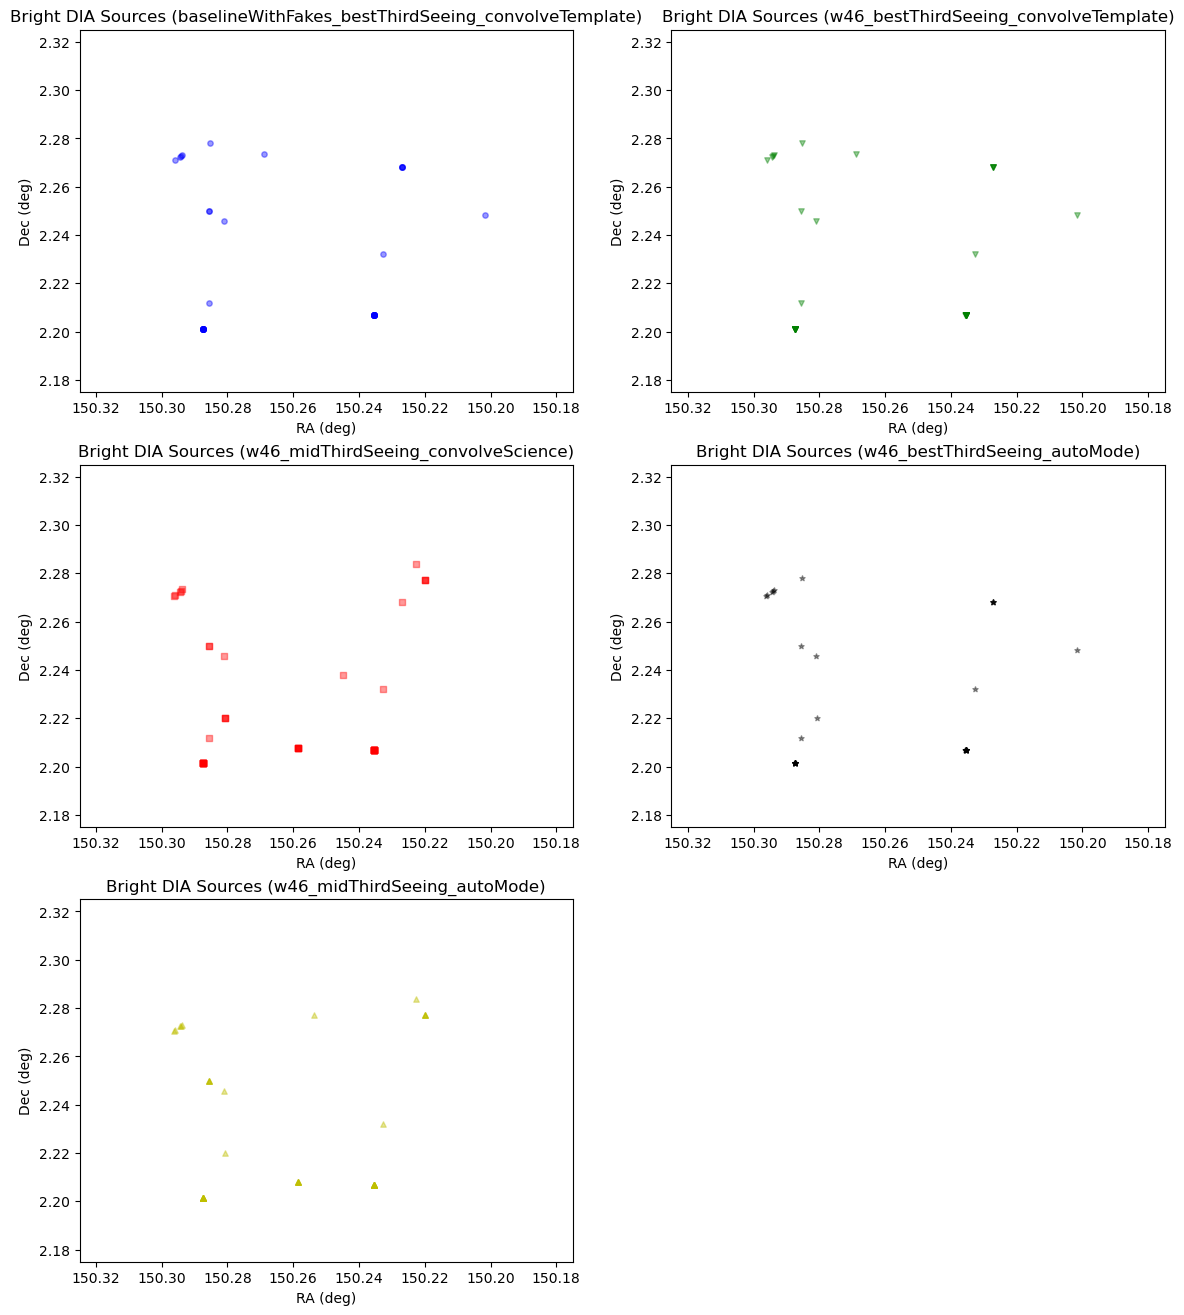

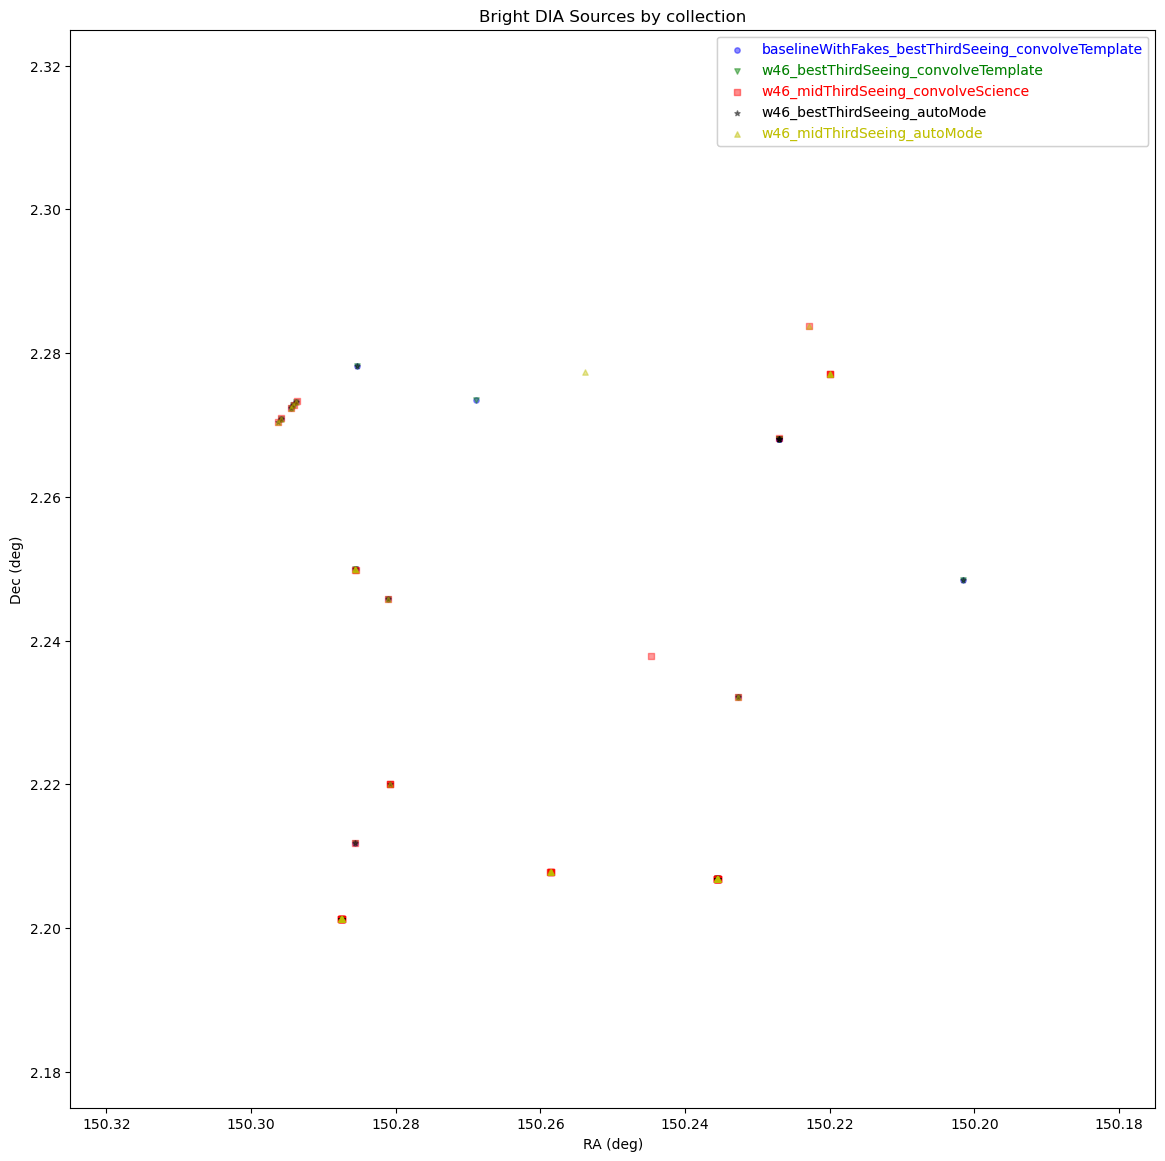

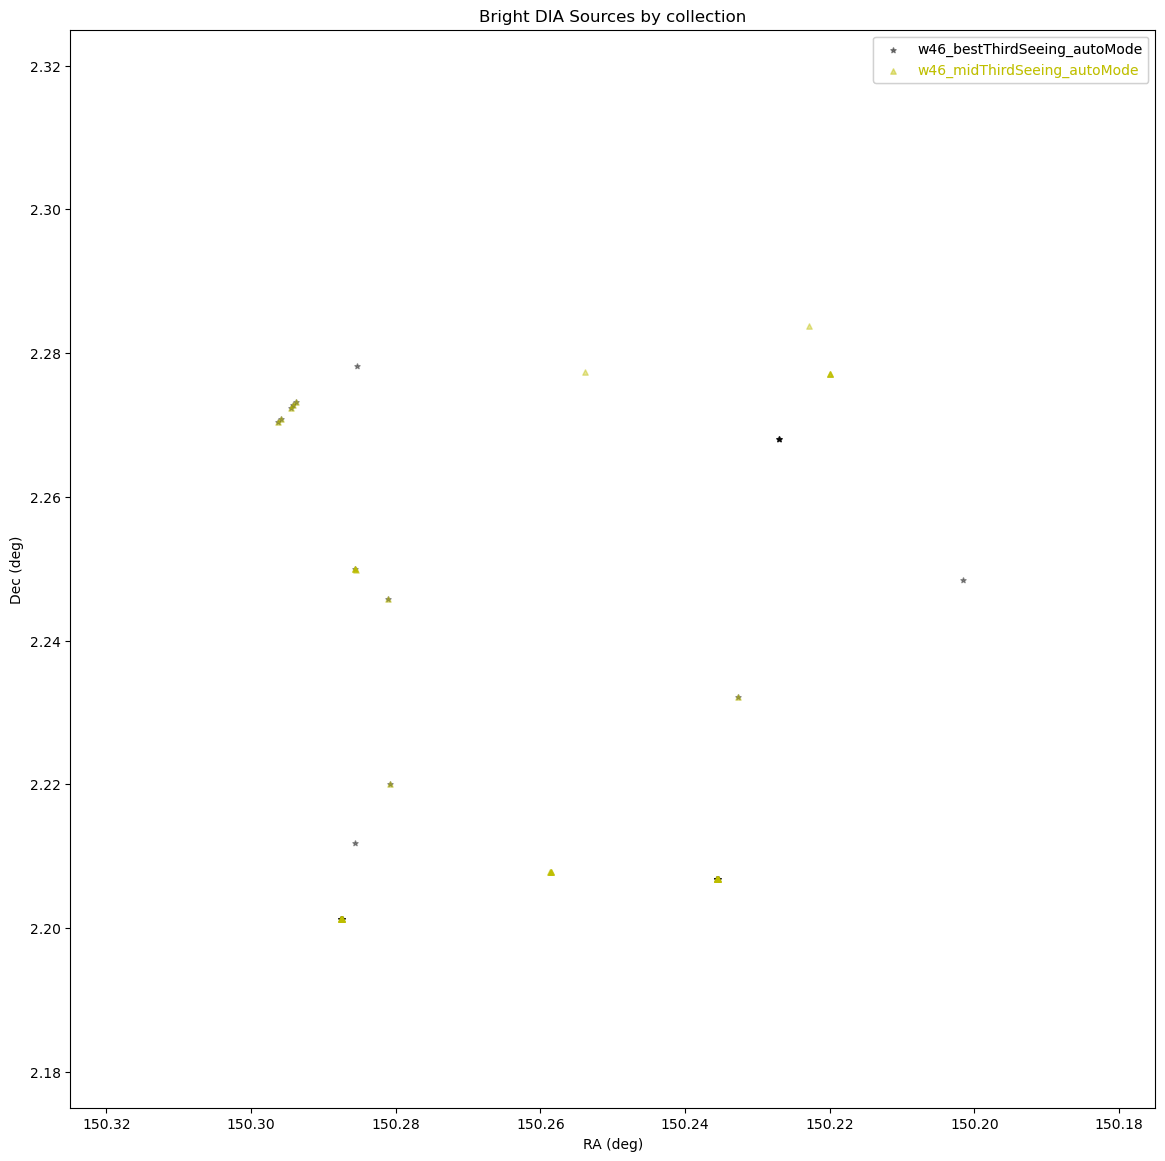

In [15]:
BSplots(fluxcut=1000,fluxtype='psFlux', RAmin=150.2, RAmax=150.3, DECmin=2.2, DECmax=2.3)

/tmp/ipykernel_7340/743899088.py:8: FutureWarning: Call to deprecated function (or staticmethod) loadTables. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable, srcTable, goodObj, goodSrc = legacyApdbUtils.loadTables(repo,
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:248: FutureWarning: Call to deprecated function (or staticmethod) loadAllApdbObjects. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable = loadAllApdbObjects(dbPath, dbType=dbType,
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:481: FutureWarning: Call to deprecated function (or staticmethod) connectToApdb. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  connection = connectToApdb(dbName, dbType, schema)
/sd

u/kherner/DM-35283/baselineWithFakes_bestThirdSeeing_convolveTemplate : 753


/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:248: FutureWarning: Call to deprecated function (or staticmethod) loadAllApdbObjects. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable = loadAllApdbObjects(dbPath, dbType=dbType,
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:481: FutureWarning: Call to deprecated function (or staticmethod) connectToApdb. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  connection = connectToApdb(dbName, dbType, schema)
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:485: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  objTab

u/kherner/DM-35283/w46_bestThirdSeeing_convolveTemplate : 746


/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:248: FutureWarning: Call to deprecated function (or staticmethod) loadAllApdbObjects. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable = loadAllApdbObjects(dbPath, dbType=dbType,
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:481: FutureWarning: Call to deprecated function (or staticmethod) connectToApdb. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  connection = connectToApdb(dbName, dbType, schema)
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:485: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  objTab

u/kherner/DM-35283/w46_midThirdSeeing_convolveScience : 934


/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:248: FutureWarning: Call to deprecated function (or staticmethod) loadAllApdbObjects. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable = loadAllApdbObjects(dbPath, dbType=dbType,
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:481: FutureWarning: Call to deprecated function (or staticmethod) connectToApdb. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  connection = connectToApdb(dbName, dbType, schema)
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:485: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  objTab

u/kherner/DM-35283/w46_bestThirdSeeing_autoMode : 788


/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:248: FutureWarning: Call to deprecated function (or staticmethod) loadAllApdbObjects. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable = loadAllApdbObjects(dbPath, dbType=dbType,
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:481: FutureWarning: Call to deprecated function (or staticmethod) connectToApdb. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  connection = connectToApdb(dbName, dbType, schema)
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:485: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  objTab

u/kherner/DM-35283/w46_midThirdSeeing_autoMode : 817


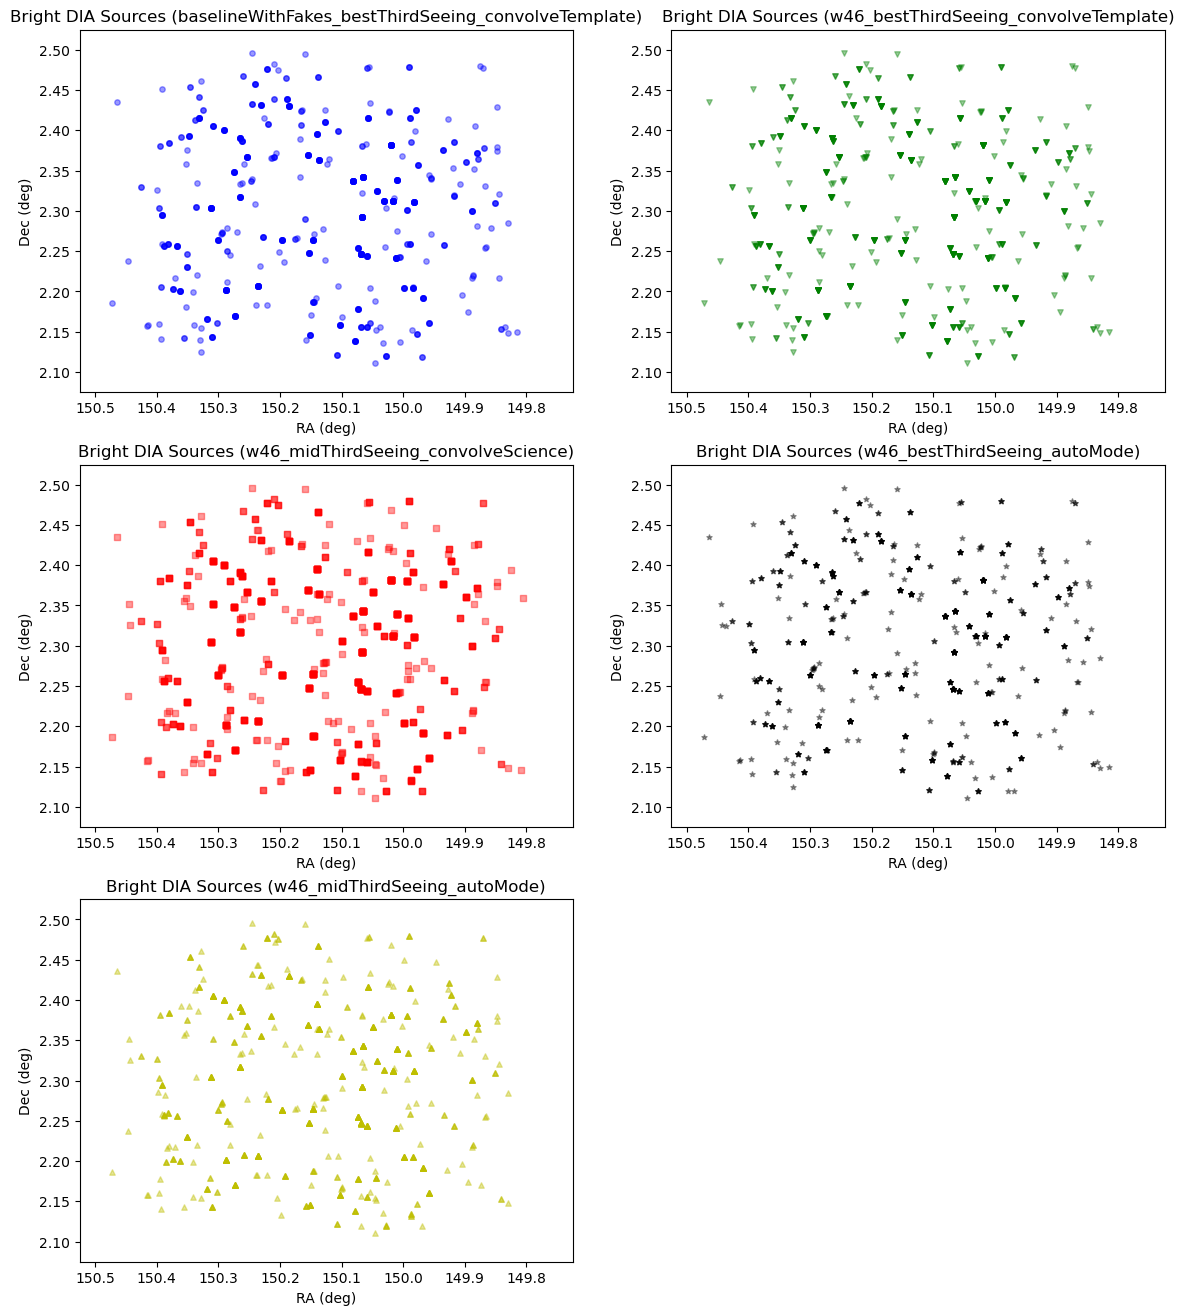

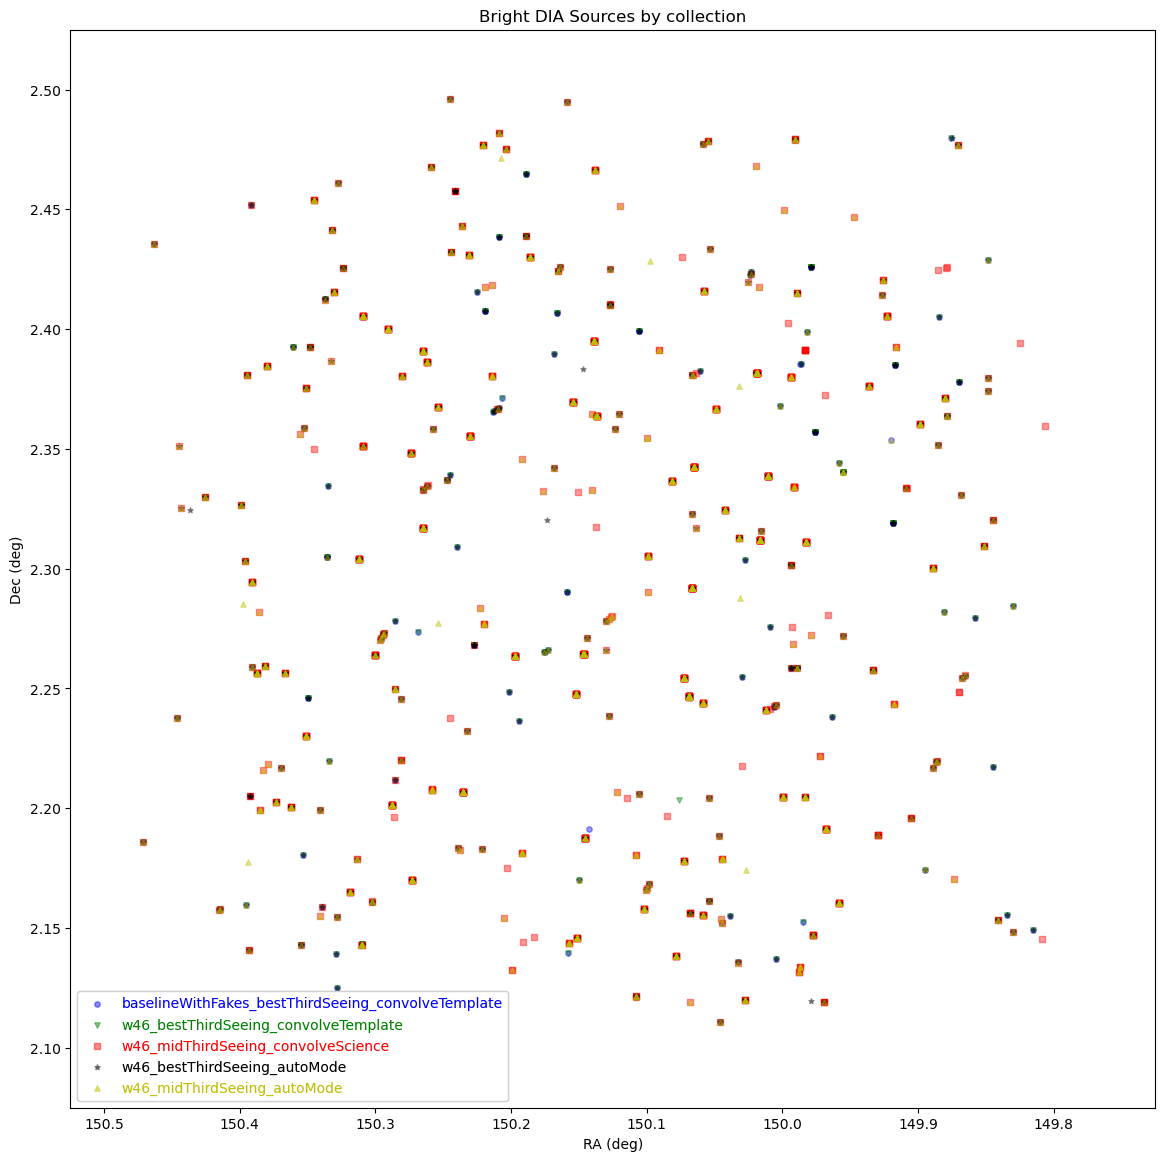

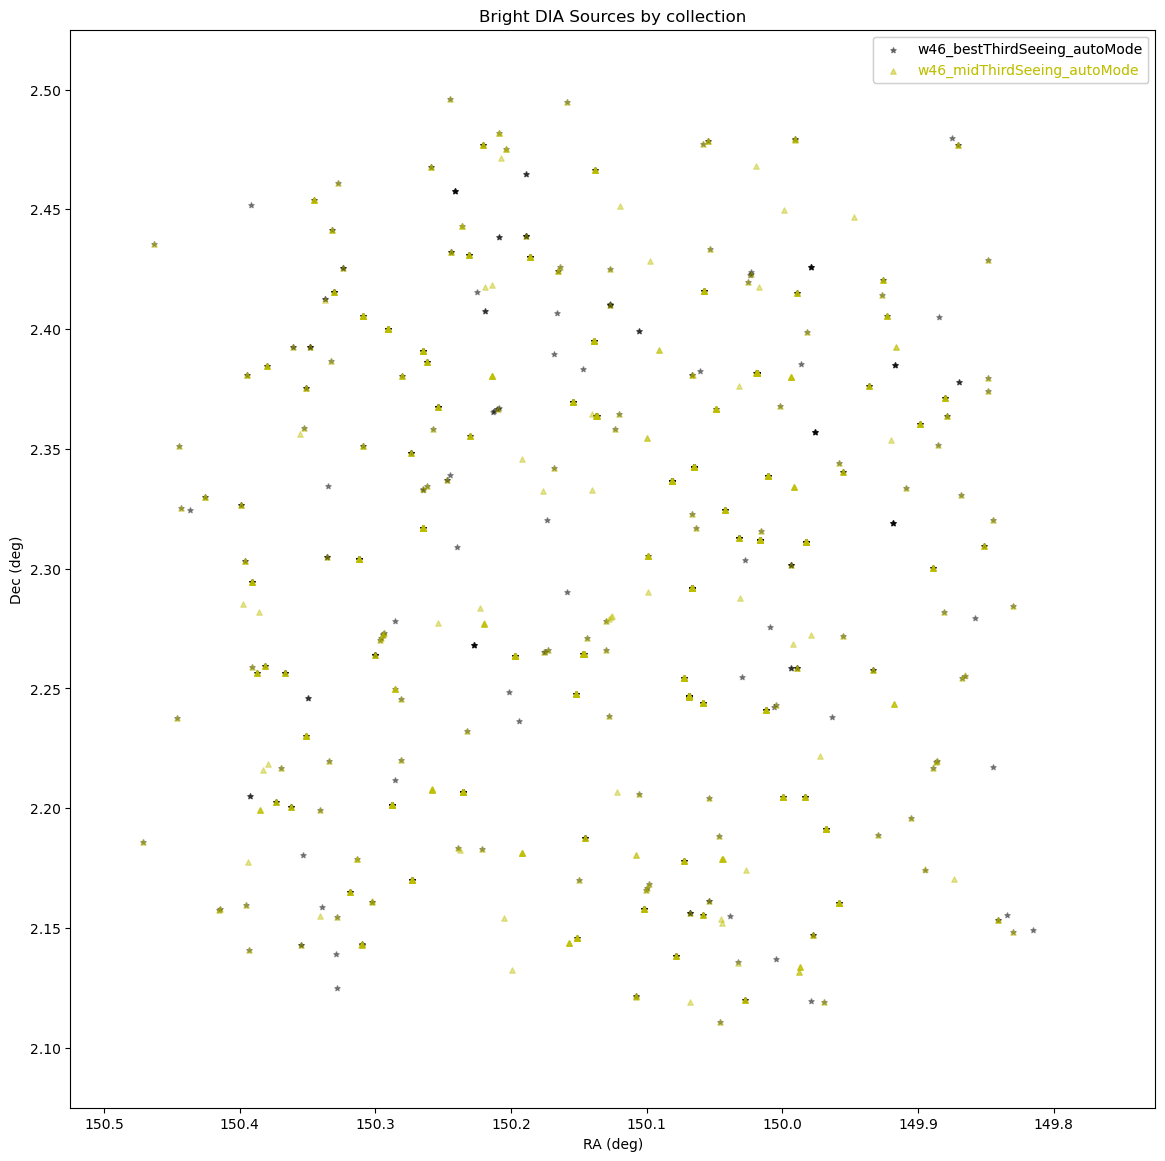

In [16]:
BSplots(fluxcut=1000,fluxtype='psFlux', RAmin=149.75, RAmax=150.5, DECmin=2.1, DECmax=2.5)

### In this next case, we allow both positive and negative flux "bright" sources.

/tmp/ipykernel_7340/743899088.py:8: FutureWarning: Call to deprecated function (or staticmethod) loadTables. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable, srcTable, goodObj, goodSrc = legacyApdbUtils.loadTables(repo,
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:248: FutureWarning: Call to deprecated function (or staticmethod) loadAllApdbObjects. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable = loadAllApdbObjects(dbPath, dbType=dbType,
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:481: FutureWarning: Call to deprecated function (or staticmethod) connectToApdb. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  connection = connectToApdb(dbName, dbType, schema)
/sd

u/kherner/DM-35283/baselineWithFakes_bestThirdSeeing_convolveTemplate : 1636


/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:248: FutureWarning: Call to deprecated function (or staticmethod) loadAllApdbObjects. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable = loadAllApdbObjects(dbPath, dbType=dbType,
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:481: FutureWarning: Call to deprecated function (or staticmethod) connectToApdb. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  connection = connectToApdb(dbName, dbType, schema)
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:485: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  objTab

u/kherner/DM-35283/w46_bestThirdSeeing_convolveTemplate : 1633


/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:248: FutureWarning: Call to deprecated function (or staticmethod) loadAllApdbObjects. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable = loadAllApdbObjects(dbPath, dbType=dbType,
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:481: FutureWarning: Call to deprecated function (or staticmethod) connectToApdb. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  connection = connectToApdb(dbName, dbType, schema)
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:485: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  objTab

u/kherner/DM-35283/w46_midThirdSeeing_convolveScience : 3517


/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:248: FutureWarning: Call to deprecated function (or staticmethod) loadAllApdbObjects. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable = loadAllApdbObjects(dbPath, dbType=dbType,
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:481: FutureWarning: Call to deprecated function (or staticmethod) connectToApdb. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  connection = connectToApdb(dbName, dbType, schema)
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:485: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  objTab

u/kherner/DM-35283/w46_bestThirdSeeing_autoMode : 1747


/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:248: FutureWarning: Call to deprecated function (or staticmethod) loadAllApdbObjects. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable = loadAllApdbObjects(dbPath, dbType=dbType,
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:481: FutureWarning: Call to deprecated function (or staticmethod) connectToApdb. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  connection = connectToApdb(dbName, dbType, schema)
/sdf/group/rubin/u/kherner/DM-35283/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:485: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  objTab

u/kherner/DM-35283/w46_midThirdSeeing_autoMode : 2038


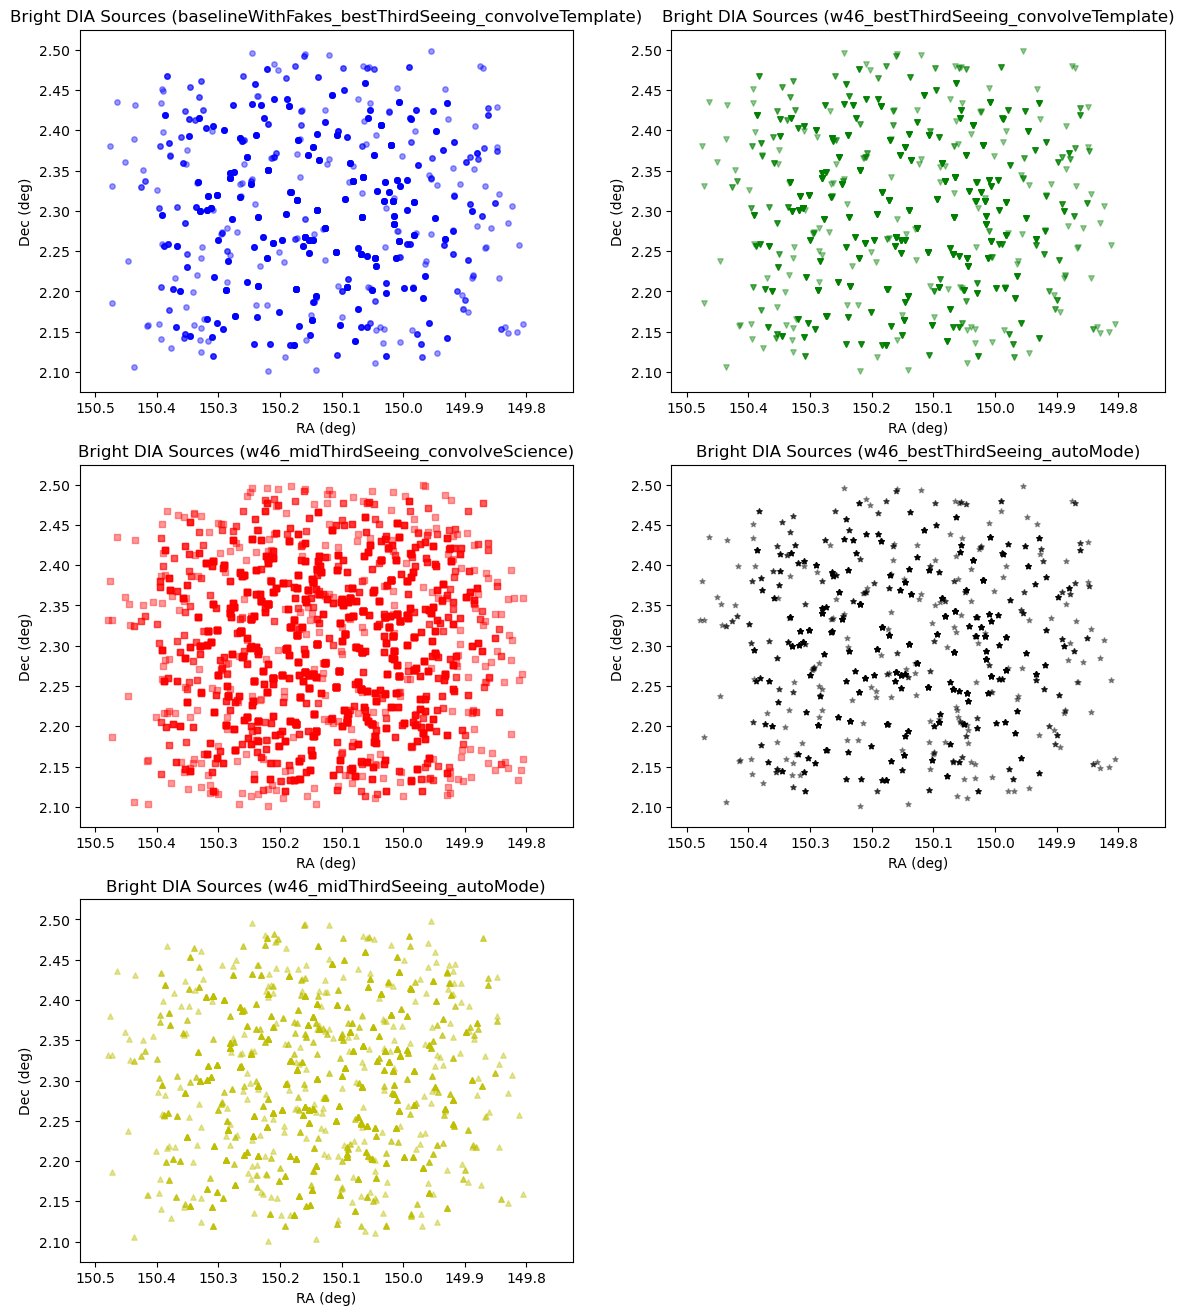

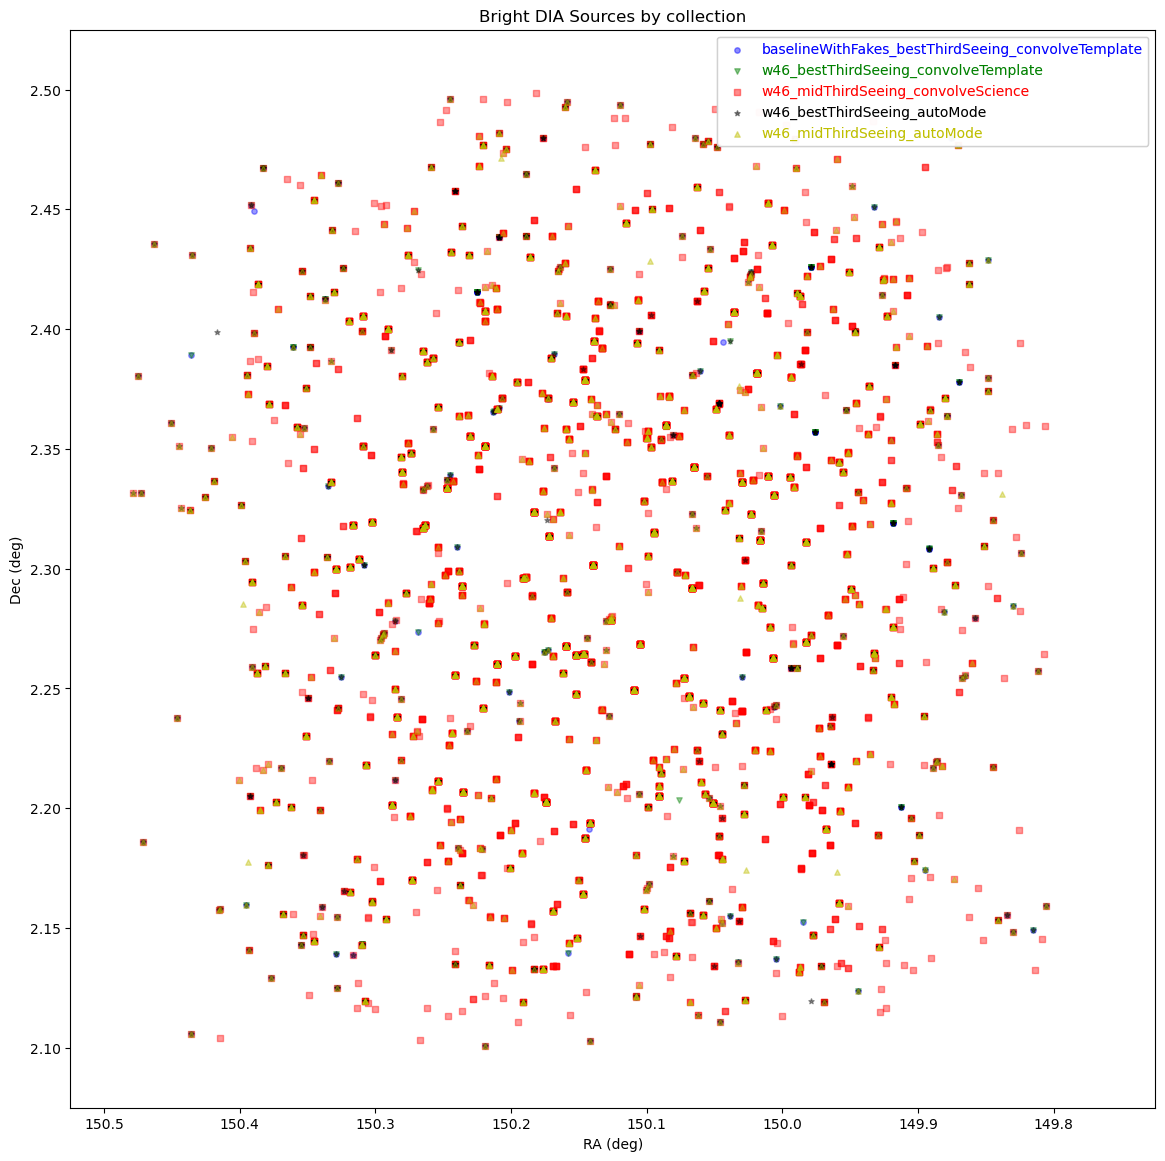

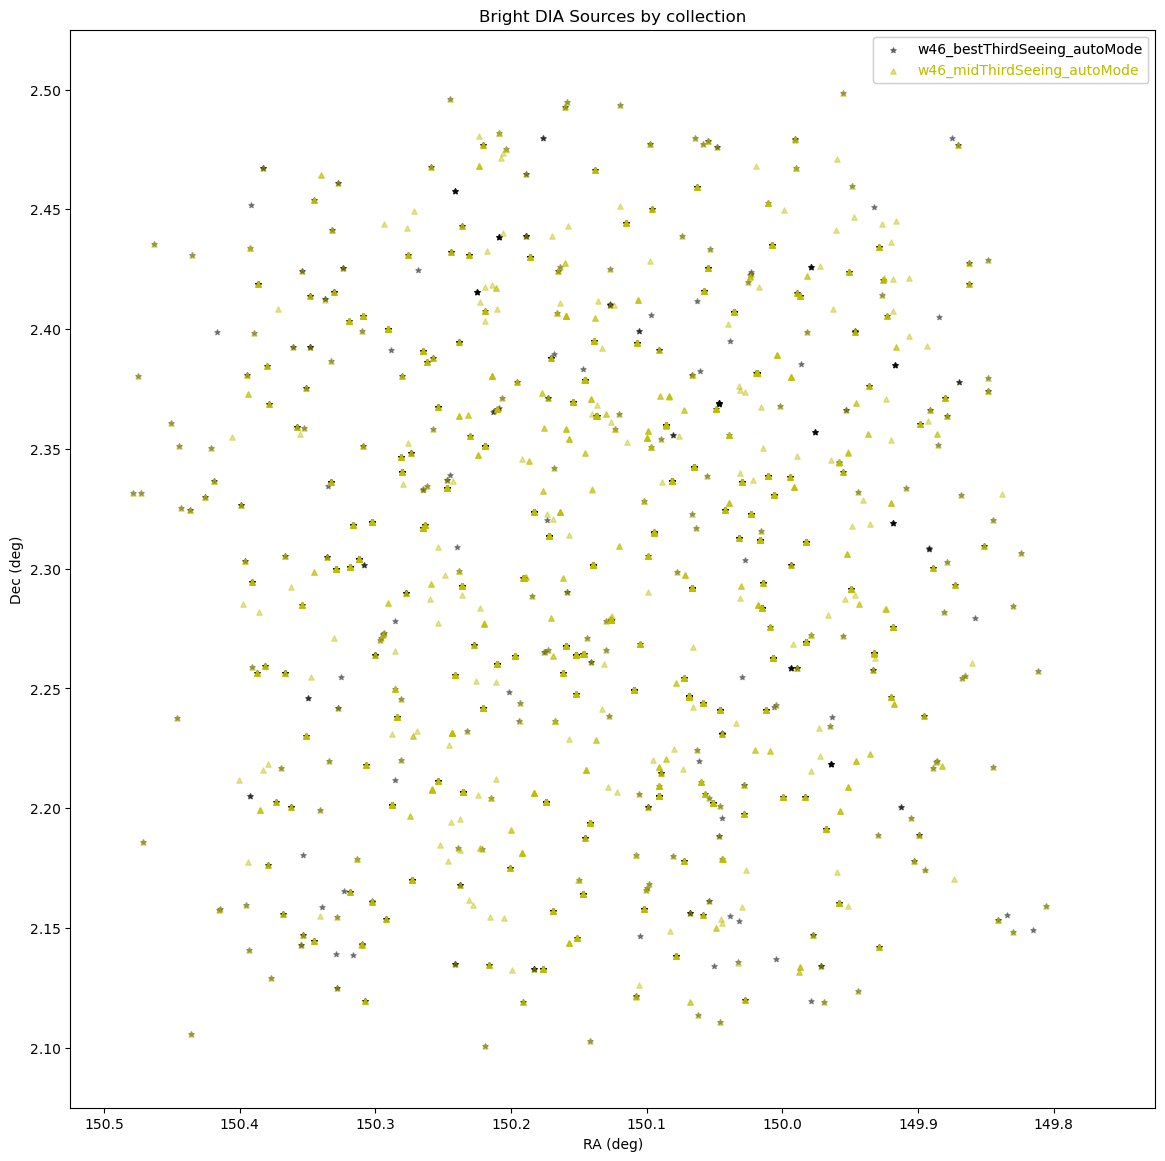

In [17]:
BSplots(fluxcut=1000,fluxtype='psFlux', RAmin=149.75, RAmax=150.5,
        DECmin=2.1, DECmax=2.5, useAbsFlux=True)

### Choose a single difference image to display for looking at the various flags. The sensor edge flags often appear in this case and correspond to the banding seen in the diffim variance plane.

In [18]:
import IPython
from IPython.display import IFrame
afwDisplay.setDefaultBackend('firefly')
display1 = afwDisplay.Display(frame=1, name='DM-35283')
IFrame(display1._url, 1000, 1200)

In [28]:
display1.mtv(diffim)

In [20]:
mydId = {"band": 'g', "skymap": 'hsc_rings_v1', "tract": 9813, "patch": 40}
mycoa = butler.get("goodSeeingCoadd",dataId=mydId, instrument='HSC', collections=collections)
# force normalizations becuase it looks like crap otherwise
gnorm = ImageNormalize(mycoa.getImage().getArray(),
                       interval=ZScaleInterval(),
                       stretch=SqrtStretch())


In [21]:
mydId = {"band": 'r', "skymap": 'hsc_rings_v1', "tract": 9813, "patch": 40}
mycoa = butler.get("goodSeeingCoadd",dataId=mydId, collections=collections)
rnorm = ImageNormalize(mycoa.getImage().getArray(),
                       interval=ZScaleInterval(),
                       stretch=SqrtStretch())

In [22]:
def mosaics(band, norm=None, nImgNorm=None):
    dataPatchList, _, _ = legacyCoaddAnalysis.getPatchConstituents(repo,
                                                                   tractIndex=9813,
                                                                   band=band,
                                                                   instrument='HSC',
                                                                   collections=collections,
                                                                   skymapName='hsc_rings_v1',
                                                                   coaddName='goodSeeingCoadd',
                                                                   verbose=False)

    legacyCoaddAnalysis.mosaicCoadd(repo, dataPatchList, band=band,
                                    tractIndex=9813, nImage=True,
                                    instrument='HSC', collections=collections,
                                    skymapName='hsc_rings_v1',
                                    filename=band+'_nImage_mosaic.png',
                                    norm=nImgNorm, coaddName='goodSeeingCoadd')
    
    legacyCoaddAnalysis.mosaicCoadd(repo, dataPatchList, band=band,
                                    tractIndex=9813, nImage=False,
                                    instrument='HSC', collections=collections,
                                    skymapName='hsc_rings_v1',
                                    filename=band+'_mosaic.png', norm=norm,
                                    coaddName='goodSeeingCoadd',
                                    show_colorbar=False)

In [23]:
collections = best_auto.collection

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-5.0.0/lib/python3.10/site-packages/astropy/visualization/mpl_normalize.py:162: RuntimeWarning: divide by zero encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-5.0.0/lib/python3.10/site-packages/astropy/visualization/mpl_normalize.py:162: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


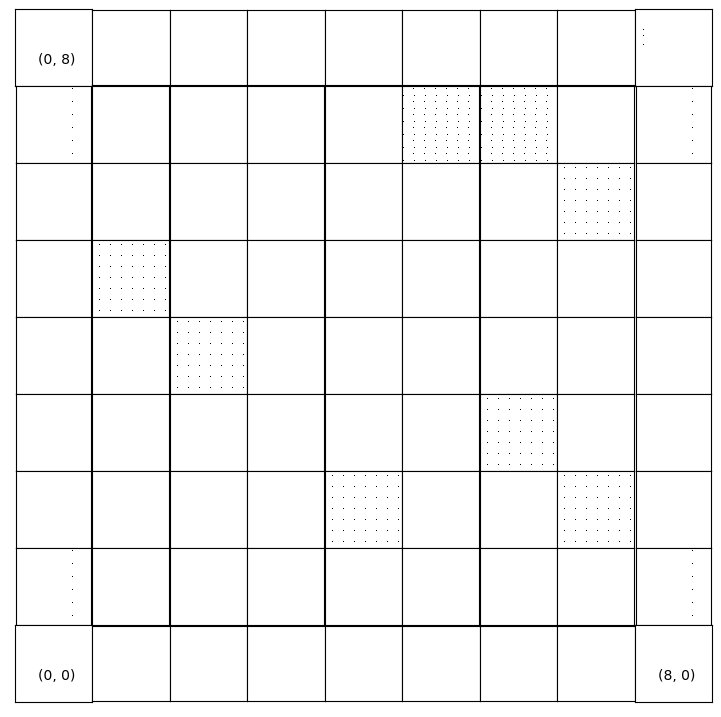

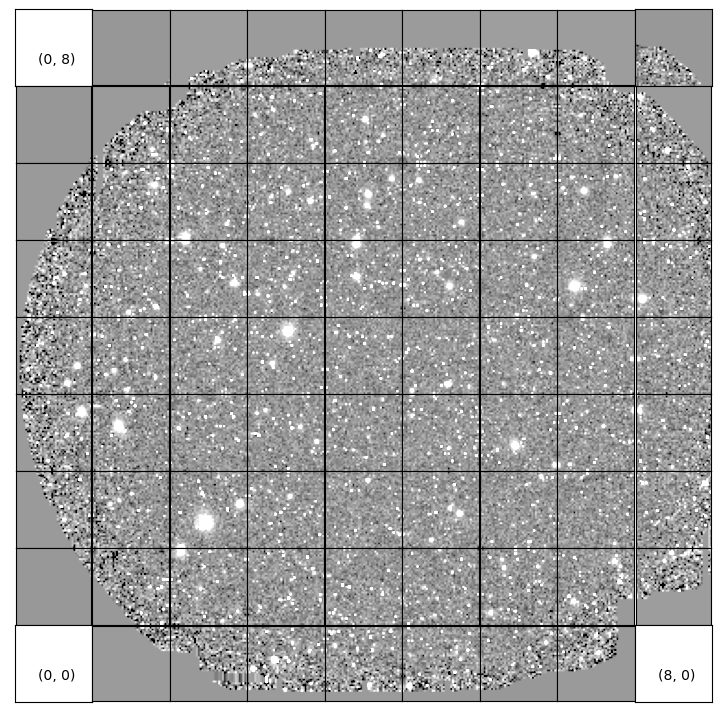

In [24]:
mosaics('g',norm=gnorm, nImgNorm=None)

In [25]:
import gc
gc.collect()

337023

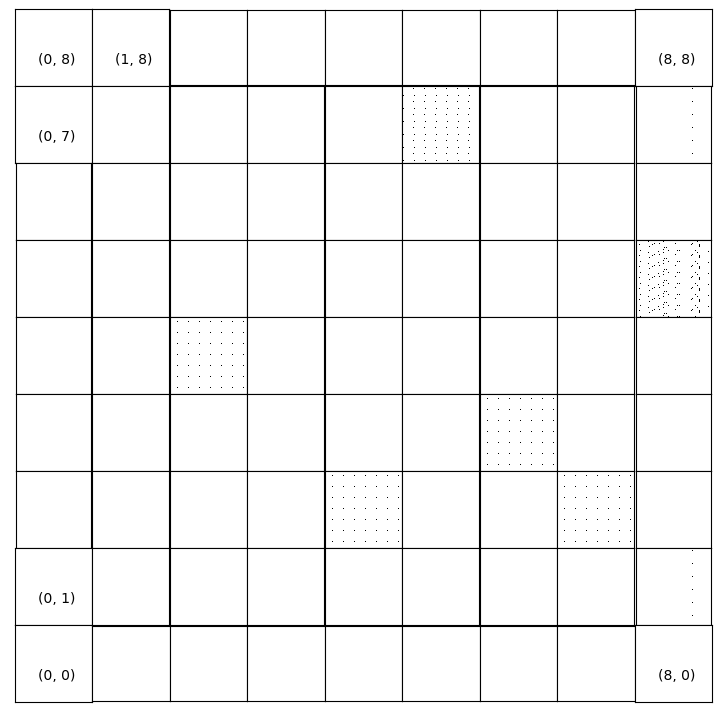

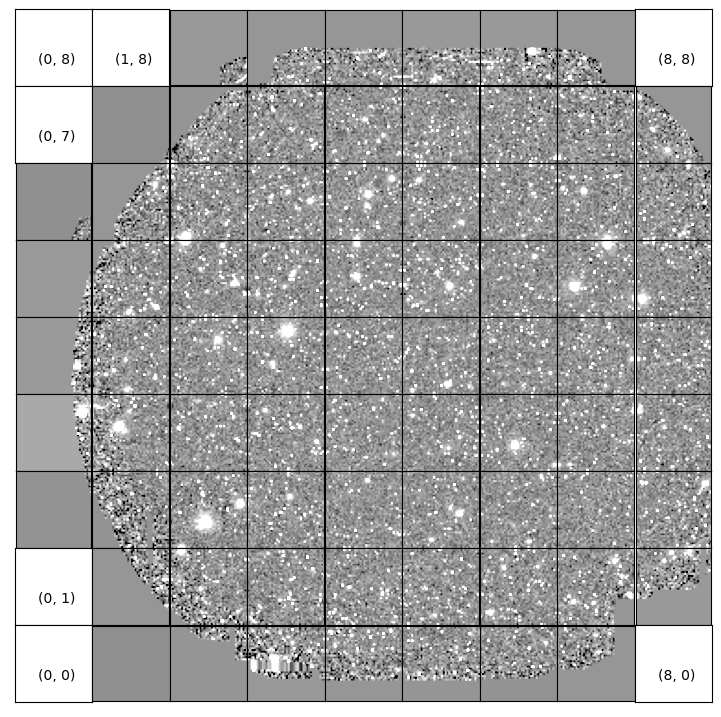

In [26]:
mosaics('r', norm=rnorm, nImgNorm=None)

In [27]:
gc.collect()

359058